In [2]:
import numpy as np
import matplotlib.pyplot as plt
import openslide
import cv2 as cv
from define_dataset import define_dataset
from color_distance import color_distance
from color_distance_bins import color_distance_bins
from color_distance_max import color_distance_max
import time
from PIL import Image

In [4]:
from define_ext_dataset import define_ext_dataset

ext_dataset = define_ext_dataset()
ext_ts_set = ext_dataset.data

num_positive_ext = ext_dataset.num_positives
num_negatives_ext = ext_dataset.num_negatives



In [3]:
def calculate_preliminary_ROI(wsi_path, full_tile_size, level):
    wsi_path = '../WSI/ext_wsi/'+slide_name+'/'+slide_name+'.tiff'
    wsi = openslide.OpenSlide(wsi_path)
    
    width_in_tiles = int(wsi.dimensions[0]/full_tile_size)
    height_in_tiles = int(wsi.dimensions[1]/full_tile_size)
    
    level_tile_size = int(full_tile_size/(2**level))
    num_tile_pixels = level_tile_size*level_tile_size

    
    preliminary_ROI_arr = np.ones([height_in_tiles, width_in_tiles], dtype=np.single)

    for x in range(width_in_tiles):
        print(wsi_path,': col ', x, ' of ', width_in_tiles, end="\r")
        for y in range(height_in_tiles):
            tile = wsi.read_region((x*full_tile_size,y*full_tile_size), 0, (full_tile_size,full_tile_size))
            
            #downsample tile
            pixel_tile = tile.resize((1, 1), resample=0)
            dominant_color = pixel_tile.getpixel((0, 0))
            if dominant_color == (0, 0, 0, 255):
                preliminary_ROI_arr[y][x] = 0

    print('\n')
                
    return preliminary_ROI_arr


Calculate bins from base white, with manual tile downsampling

In [4]:
def calculate_ROI_bins(slide_name, level, full_tile_size, base_white, num_bins):
    wsi_path = '../WSI/ext_wsi/'+slide_name+'/'+slide_name+'.tiff'
    wsi = openslide.OpenSlide(wsi_path)
    preliminary_ROI_arr = np.load('../WSI/ext_wsi/'+slide_name+'/roi_preliminary.npy')

    
    width_in_tiles = int(wsi.dimensions[0]/full_tile_size)
    height_in_tiles = int(wsi.dimensions[1]/full_tile_size)
    
    level_tile_size = int(full_tile_size/(2**level))

    bins = np.zeros(num_bins)
    for x in range(width_in_tiles):
        print(wsi_path,': col ', x, ' of ', width_in_tiles, end="\r")
        for y in range(height_in_tiles):
            if preliminary_ROI_arr[y][x] == 0:
                tile = wsi.read_region((x*full_tile_size,y*full_tile_size), 0, (full_tile_size,full_tile_size))

                #downsample tile
                scaled_tile = tile.resize((level_tile_size, level_tile_size))

                #color distance is normalized in range (0,100)
                bins = np.add(bins,color_distance_bins(scaled_tile, base_white, num_bins=num_bins))
    print('\n')
    
    return bins

Calculate ROI mask excluding tiles over maximum, with manual tile downsampling

In [5]:
def calculate_ROI(wsi_path, full_tile_size, level, threshold_white, base_white, max_distance):
    wsi = openslide.OpenSlide(wsi_path)
    width_in_tiles = int(wsi.dimensions[0]/full_tile_size)
    height_in_tiles = int(wsi.dimensions[1]/full_tile_size)
    #print('num tiles width', width_in_tiles)
    #print('num tiles heigth', height_in_tiles)
    preliminary_ROI_arr = np.load('../WSI/ext_wsi/'+slide_name+'/roi_preliminary.npy')

    
    
    level_tile_size = int(full_tile_size/(2**level))
    ROI_map_arr = np.ones([height_in_tiles, width_in_tiles], dtype=np.single)
    num_tile_pixels = level_tile_size*level_tile_size

    
    for x in range(width_in_tiles):
        print(wsi_path,': col ', x, ' of ', width_in_tiles, end="\r")
        for y in range(height_in_tiles):
            if preliminary_ROI_arr[y][x] == 1:

                tile = wsi.read_region((x*full_tile_size,y*full_tile_size), 0, (full_tile_size,full_tile_size))

                #downsample tile
                scaled_tile = tile.resize((level_tile_size, level_tile_size))

                num_white_pixel = color_distance_max(scaled_tile, base_white, threshold_white, max_distance=max_distance, num_tile_pixels=num_tile_pixels)
                white_pixel_ratio = num_white_pixel/num_tile_pixels
                ROI_map_arr[y][x] = white_pixel_ratio
    return ROI_map_arr

In [5]:
def exec_closing_opening(threshold_ROI_map):
    kernel = np.ones((3,3), np.uint8)
    
    #removes "holes" in ROI
    img_dilated1 = cv.dilate(threshold_ROI_map, kernel, iterations=1)
    img_eroded1 = cv.erode(img_dilated1, kernel, iterations=1)
    #removes "islands"
    img_eroded2 = cv.erode(img_eroded1, kernel, iterations=1)
    img_dilated2 = cv.dilate(img_eroded2, kernel, iterations=1)
    
    
    return img_dilated2.astype(int)

Calculate preliminary ROI to exclude black cut portions in some WSIs

In [11]:
level = 5
full_tile_size = 256

start_time = time.time()


for i, slide_name in enumerate(ext_ts_set):
    wsi_path = '../WSI/ext_wsi/'+slide_name+'/'+slide_name+'.tiff'
    print(wsi_path)
    preliminary_ROI_arr = calculate_preliminary_ROI(wsi_path, full_tile_size, level)
    np.save('../WSI/ext_wsi/'+slide_name+'/roi_preliminary.npy', preliminary_ROI_arr)
    
end_time = time.time()
print('time: ', "{:.0f}".format(end_time - start_time))

../WSI/ext_wsi/M-3784-20-A1 SP142/M-3784-20-A1 SP142.tiff
../WSI/ext_wsi/M-3784-20-A1 SP142/M-3784-20-A1 SP142.tiff : col  335  of  336

time:  1155


In [13]:
level = 3
full_tile_size = 256
base_white = [238,238,238]
num_bins = 100

start_time = time.time()
wsi_bins = []

wsi_set = ext_ts_set
for slide_name in wsi_set:    
    bins = calculate_ROI_bins(slide_name, level, full_tile_size, base_white, num_bins)
    wsi_bins.append(bins)
    
end_time = time.time()
print('time: ', "{:.0f}".format(end_time - start_time))



avg = np.average(wsi_bins, axis=0)
std = np.std(wsi_bins, axis=0)
max_bins = np.zeros(len(ext_ts_set), dtype='int')

for i, slide_name in enumerate(ext_ts_set):
    max_bins[i] = num_bins
    #consider outliers bins only in the upper 50%
    for y in range(num_bins-1, 5*(int(num_bins/10))-1, -1):
        if wsi_bins[i][y]> avg[y]+(3*std[y]):
            print(slide_name, "bin", y, "over thresh")
            max_bins[i] = y-1
            
np.save('max_distance_test_ext.npy', max_bins)

../WSI/ext_wsi/M-834-21 SP142/M-834-21 SP142.tiff : col  325  of  326

../WSI/ext_wsi/M-534-20-1 SP142/M-534-20-1 SP142.tiff : col  311  of  312

../WSI/ext_wsi/M-527-20 MA2-SP142/M-527-20 MA2-SP142.tiff : col  165  of  166

../WSI/ext_wsi/M-527-20 MA1-SP142/M-527-20 MA1-SP142.tiff : col  196  of  197

../WSI/ext_wsi/M-360-20 SP142/M-360-20 SP142.tiff : col  366  of  367

../WSI/ext_wsi/M-313-20 SP142/M-313-20 SP142.tiff : col  208  of  209

../WSI/ext_wsi/M-182-20-A1 SP142/M-182-20-A1 SP142.tiff : col  218  of  219

../WSI/ext_wsi/M-180-20 SP142/M-180-20 SP142.tiff : col  150  of  151

../WSI/ext_wsi/M-67-21-1-SP142 (4)/M-67-21-1-SP142 (4).tiff : col  244  of  245

time:  19


In [6]:
level = 3
threshold_white = 5
#tile size at level 0 (full resolution)
full_tile_size = 256
base_white = [238,238,238]
max_distance = np.load('max_distance_test_ext.npy')

start_time = time.time()

for i, slide_name in enumerate(ext_ts_set):
    wsi_path = '../WSI/ext_wsi/'+slide_name+'/'+slide_name+'.tiff'
    ROI_map_arr = calculate_ROI(wsi_path, full_tile_size, level, threshold_white, base_white, max_distance[i])
    np.save('../WSI/ext_wsi/'+slide_name+'/roi_enhanced.npy', ROI_map_arr)
    print('\n')
    print('completed slide: '+ slide_name)
    
end_time = time.time()
print('time: ', "{:.0f}".format(end_time - start_time))


../WSI/ext_wsi/M-3784-20-A1 SP142/M-3784-20-A1 SP142.tiff : col  335  of  336

completed slide: M-3784-20-A1 SP142
time:  1363


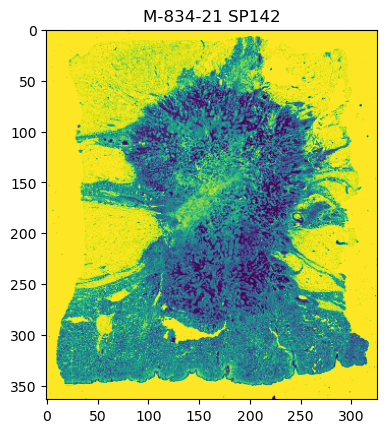

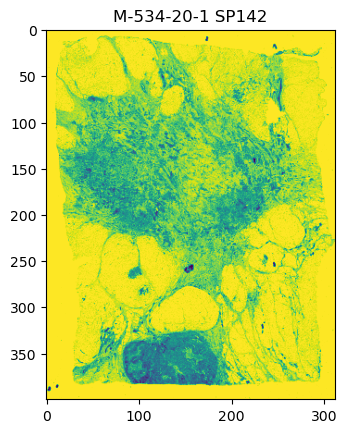

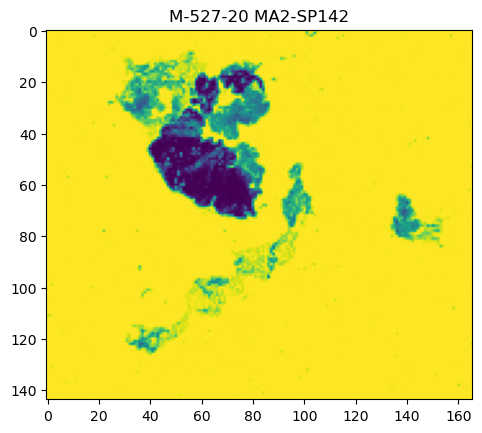

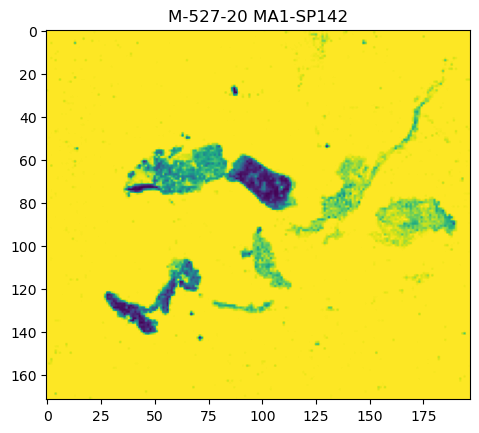

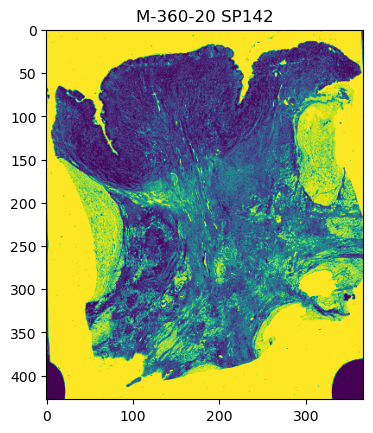

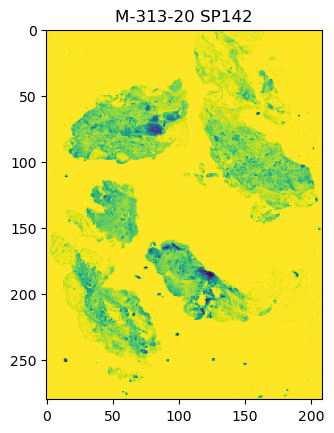

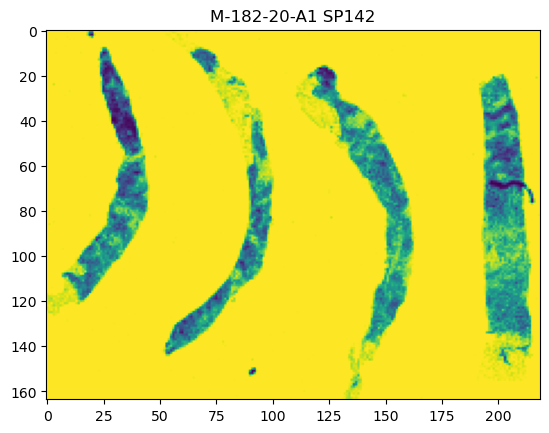

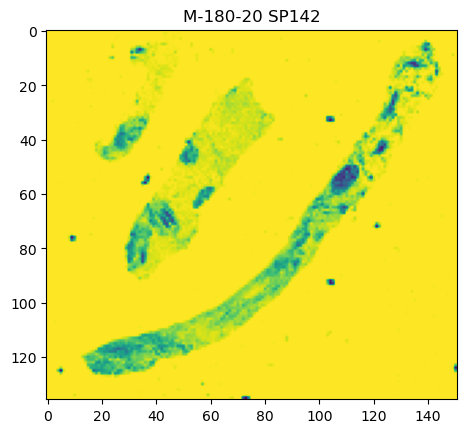

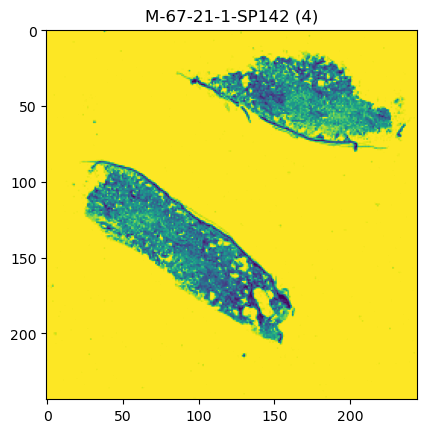

In [15]:
for slide_name in ext_ts_set:
    ROI_map_arr = np.load('../WSI/ext_wsi/'+slide_name+'/roi_enhanced.npy')
    
    plt.imshow(ROI_map_arr)
    plt.title(slide_name)
    plt.show()

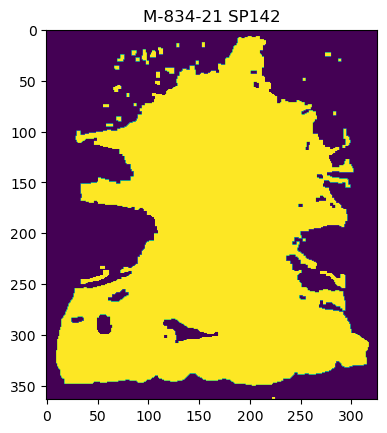

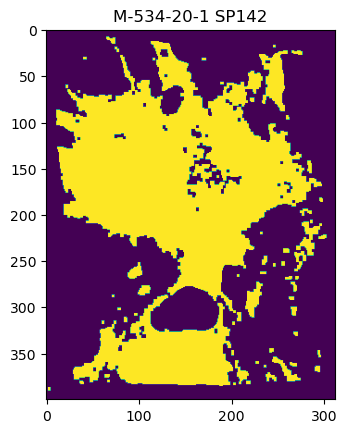

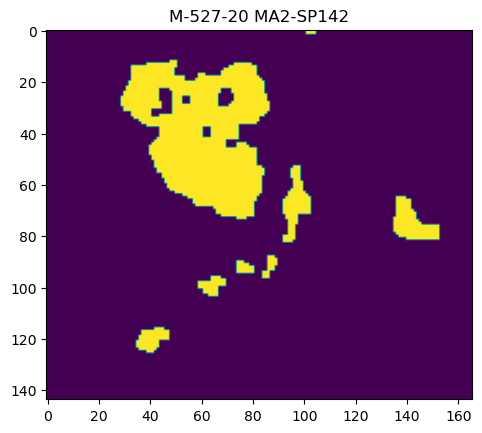

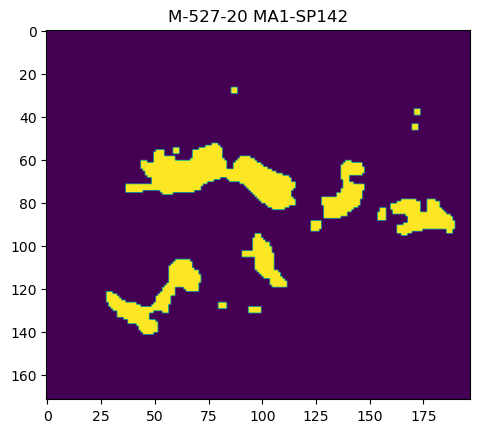

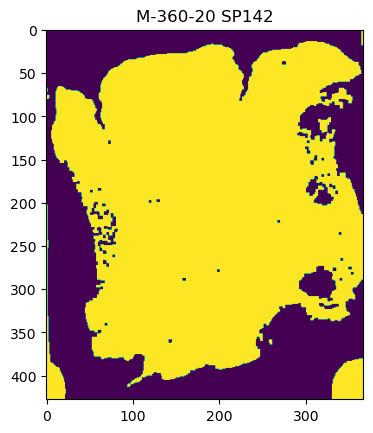

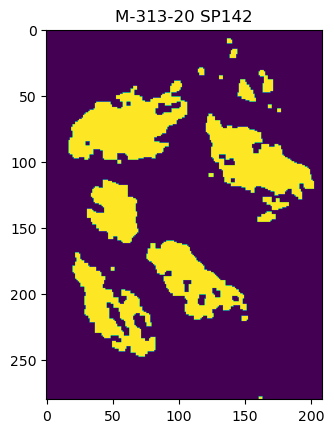

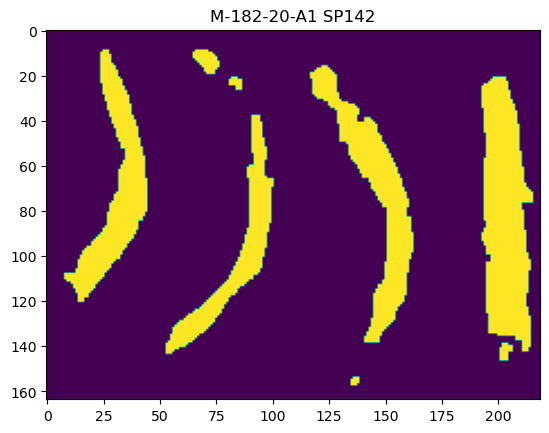

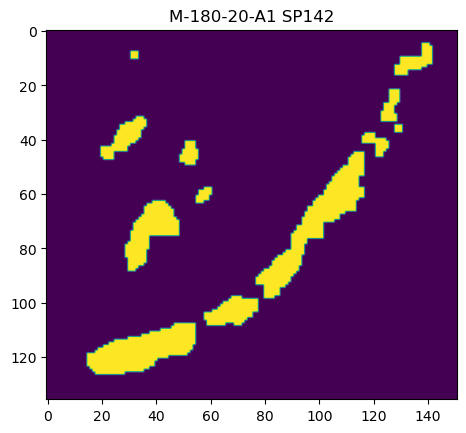

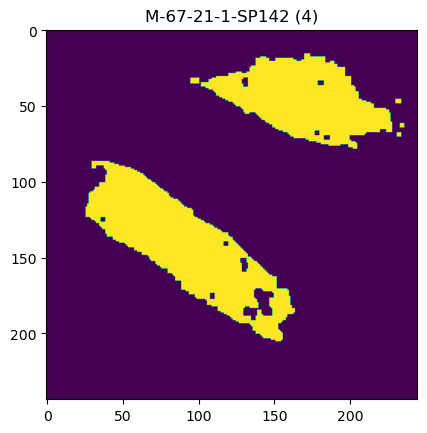

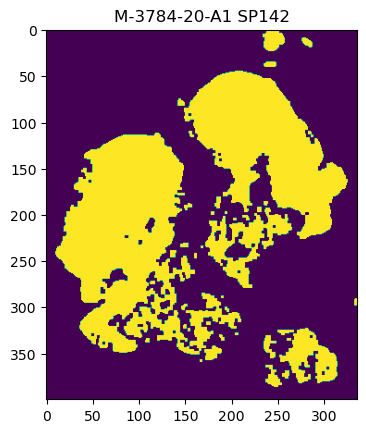

In [6]:
tile_percentage_threshold = 0.85
 
for slide_name in ext_ts_set:
    ROI_map_arr = np.load('../WSI/ext_wsi/'+slide_name+'/roi_enhanced.npy')
    threshold_ROI_map = (ROI_map_arr<tile_percentage_threshold*np.max(ROI_map_arr)).astype(float)     
    #threshold_ROI_map = (ROI_map_arr<tile_percentage_threshold).astype(float)     
    ROI_map_op_cl = exec_closing_opening(threshold_ROI_map)
    np.save('../WSI/ext_wsi/'+slide_name+'/roi_'+str(tile_percentage_threshold)+'_enhanced.npy', ROI_map_op_cl)

    plt.imshow(ROI_map_op_cl)
    plt.title(slide_name)
    plt.show()